In [1]:
# standard imports
import sys
import numpy as np
from tqdm import tqdm
import meshio
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [2]:
# import geometry classes
from geometry.node import node
from geometry.cell import cell
from geometry.mesh import rot_sym_mesh

# problem defining operators
from problem.isentropic_navier_stokes import convection, diffusion, skalar_product, curl

# projection based functions
from utilities.projection import isentropic_projection, isentropic_control_projection

# utility functions
from utilities.utilities import *
from utilities.pod import get_POD, get_activations

# reloading modules

In [3]:
modName = "utilities.projection"
del sys.modules[modName]
from utilities.projection import isentropic_projection, isentropic_control_projection

# Setting Custom Problem

In [4]:
# read su2 mesh file
meshio_mesh = meshio.read("./mesh_files/mesh_cylinder_quad.su2",file_format="su2")
# convert mesh into custom class
mesh = rot_sym_mesh(meshio_mesh)

    Surface tag  cylinder will be replaced by 1
    Surface tag  farfield will be replaced by 2


Initializing Mesh---------------------------------------------------------------
Mesh Initialization Successful!-------------------------------------------------


# Parameter List

In [5]:
# PROBLEM CONSTANTS
n = mesh.n                  # number of nodes
N = mesh.N                  # number of cells
T = 220                     # number of snapshots
nu = 1.716e-5               # kinematic viscosity
mach = 0.6                  # mach number
sos = 340.29                # isentropic speed of sound
uInfty = mach * sos         # freestream velocity
Re = 100                    # Reynolds number of freeflow
dt = 0.0001                 # simulation time step
subsampling = 6             # subsampling for data
nondim = False              # nondimensionalization of results
chirp = True                # chirp dataset

# POD PARAMETERS
maxPOD = 12                 # maximum number of POD modes
gamma = 1.4                 # isentropic coefficient -> material property
alpha = 1/gamma             # inner product coefficient [(gamma - 1)/2 -> standard, 1 -> stagnation enthalpy]
include_avg = False         # include average flow in POD computation

# GALERKIN PARAMETERS
stabilization = "viscosity" # stabilization method for galerkin system
epsilon = 1e-4              # weight for sobolev norm stabilization -> experimental
if mach == 0.6:
    dt_ref = 0.0001 * subsampling     # snapshot equaivalent time step
    dt = 0.0005                       # galerkin time step
    shed_period = 0.0327              # hypothesized shed period
elif mach == 0.1:
    dt_ref = 0.001 * subsampling
    dt = 0.001
    shed_period = 0.18
elif mach == 0.01:
    dt_ref = 0.02 * subsampling
    dt = 0.02
    shed_period = 1.84
t0 = 0
tmax = shed_period * 10
temporalSpan = np.linspace(t0,tmax,int(tmax/dt)+1)

# OPTIMIZATION PARAMETERS
designDim = 8                       # number of design parameters
designVars = np.ones(designDim)     # design variables for gamma
control0 = 0                        # initial control
gamma_max = 10                      # maximum allowable control
phi0 = 0                            # costate end condition
epsilon = 1e-4                      # discontinuation criteria

In [6]:
# reading file data
dataDir  = "./flow_data/lam_cyl_comp_air/mach 0.6 chirp/"
dataDict = read_csv_data(dataDir,delay=0,subsampling=subsampling,max_size=T)

# geometric information
x = dataDict["x"][:,0] - 0.5
y = dataDict["y"][:,0]

# fluid velocity and mach number
u = np.divide(dataDict['Momentum_x'], dataDict['Density'])
v = np.divide(dataDict['Momentum_y'], dataDict['Density'])
a = dataDict['Mach']

# construct state based data
q = np.vstack([u,v,a])
T = q.shape[1]
qAvg = np.mean(q,1)
qFluc = q - np.repeat(np.expand_dims(qAvg,1),T,axis=1)

# data for pod decomposition
if include_avg:
    podData = q
else:
    podData = qFluc

100%|██████████| 220/220 [01:13<00:00,  2.99it/s]


In [7]:
### set scalar weights for multiplicative computation
# volume participations
volumeWeight = mesh.volume_weights
# additional weight for speed of sound
machWeight = (2 * alpha / (gamma - 1))
# construction of weights
innerWeight = np.concatenate([np.ones(n),np.ones(n),machWeight*np.ones(n)]) * volumeWeight

In [8]:
def skalar_product(q1,q2,weights=innerWeight):
    return np.sum(q1*q2*weights)

# POD Decomposition

In [9]:
[podModes, S] = get_POD(podData,skalar_product,20)
coeffs = get_activations(podData,podModes,skalar_product,20)
if nondim:
    coeffs /= uInfty

In [10]:
# energy reconstruction threshold
epsilon = 0.99
acc = 0
dim = 0
while acc < epsilon:
    dim+=1
    acc = sum(S[:dim])/sum(S)    
print("Number of eigenvectors necessary for thresholded reconstruction: \t" + str(dim))
if dim % 2 == 1:
    dim+=1

# manual value assignement
dim = 4

Number of eigenvectors necessary for thresholded reconstruction: 	4


In [11]:
# plot_activations(coeffs,dim,dt=dt*subsampling)

# Control Data Input

In [12]:
controlDir  = "./flow_data/lam_cyl_comp_air/potVortex_0.6_1/"
controlDict = read_csv_data(controlDir,0,1,1)

uCon = np.divide(controlDict['Momentum_x'], controlDict['Density'])
vCon = np.divide(controlDict['Momentum_y'], controlDict['Density'])
aCon = controlDict['Mach']

# construct state based data
qCon = np.vstack([uCon,vCon,aCon]).squeeze()

100%|██████████| 1/1 [00:00<00:00,  3.21it/s]


# Galerkin Coefficients

In [13]:
[b1, b2, L1, L2, Q] = isentropic_projection(mesh,podModes[:,:dim],qAvg,skalar_product)

100%|██████████| 4/4 [00:00<00:00, 186.02it/s]

Projection based Galerkin coefficients in order: b1,b2,L1,L2,Q


# Control Function Method
Additional coefficients in Galerkin system

In [14]:
[d1,d2,f,g,h] = isentropic_control_projection(mesh,podModes[:,:dim],qAvg,qCon,skalar_product)

100%|██████████| 4/4 [00:01<00:00,  2.73it/s]

Additional projection based Galerkin coefficients for control in order: d1, d2, f, g, h


# Galerkin System

In [15]:
# initial conditions
a0 = coeffs[:dim,0]

# dynamic viscosity for stabilization
if stabilization=="viscosity":
    if mach == 0.6:
        # tuned
        if dim == 10:
            nu = 4.09 if chirp==False else 2.29 # 10 modes
        elif dim == 8:
            nu = 3.24 if chirp==False else 2.1  # 8 modes
        elif dim == 6:
            nu = 3.07 if chirp==False else 1.9  # 6 modes
        elif dim == 4:
            nu = 3.625 if chirp==False else 2.45# 4 modes
        elif dim == 2:  
            nu = 4.36  if chirp==False else 3.05# 2 modes

    elif mach == 0.1:
        # tuned
        if dim == 10:
            nu = 0.745   # 10 modes
        elif dim == 8:
            nu = 0.7445  # 8 modes
        elif dim == 6:
            nu = 0.7390  # 6 modes
        elif dim == 4:
            nu = 0.7635  # 4 modes
        elif dim == 2:  
            nu = 0.8625  # 2 modes

    elif mach == 0.01:
        # tuned
        if dim == 10:
            nu = 0.1535  # 10 modes
        elif dim == 8:
            nu = 0.151   # 8 modes
        elif dim == 6:
            nu = 0.1515  # 6 modes
        elif dim == 4:
            nu = 0.1515  # 4 modes
        elif dim == 2:  
            nu = 0.1550  # 2 modes

In [16]:
# defining ode function for node based coefficients
def galerkin_system(t,a):
    # set global variables references
    global Q, L1, L2, b1, b2, nu
    a_dot = np.empty_like(a)
    for k in range(a_dot.shape[0]):
        a_dot[k] = (nu * b1[k] + b2[k] + np.inner((nu * L1[k,:] + L2[k,:]),a) + np.matmul(np.matmul(np.expand_dims(a,1).T,Q[k]),np.expand_dims(a,1))) 
    return a_dot

In [17]:
sol = solve_ivp(galerkin_system,(t0,tmax),a0, method='LSODA',t_eval=temporalSpan)
sol.message

'The solver successfully reached the end of the integration interval.'

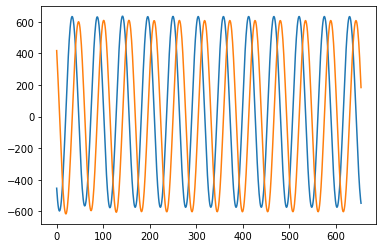

In [18]:
for i in range(2):
    plt.plot(sol.y[i,:])

# Comparison of Limit Cycles

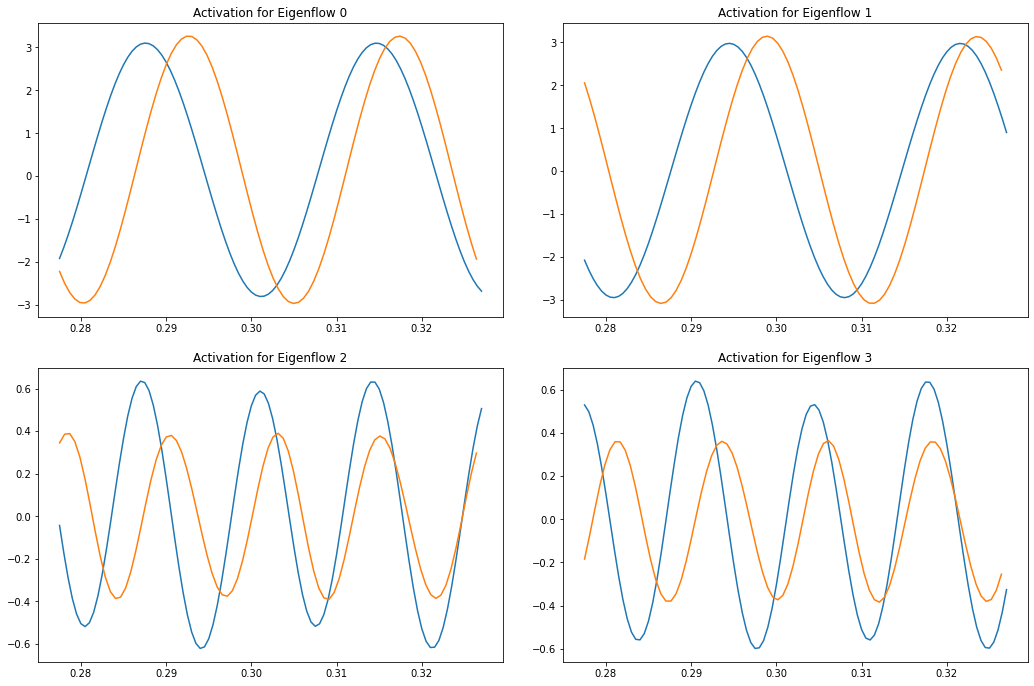

In [19]:
# Galerkin model 
d = int(dim/2)
fig,ax = plt.subplots(d,2,figsize=(15,10))
fig.tight_layout(pad=3.0)

t = temporalSpan 
phase_shift = 54
plot_time_span = 100 * dt
orig_number = int(plot_time_span / (dt_ref)) #  *1.12))
t_orig = np.linspace(t[-100],tmax-dt_ref,num=orig_number)

# add plots over full time domain
for i in range(dim):
    if dim <= 2:
        ax[int(i%2)].plot(t[-100:],sol.y[i,-100:]/(sos * mach))
        ax[int(i%2)].plot(t_orig,coeffs[i,-(orig_number + phase_shift):-phase_shift]/(sos * mach))
        ax[int(i%2)].title.set_text("Activation for Eigenflow " + str(i))
    else:
        ax[int(i/2)][int(i%2)].plot(t[-100:],sol.y[i,-100:]/(sos * mach))
        ax[int(i/2)][int(i%2)].plot(t_orig,coeffs[i,-(orig_number + phase_shift):-phase_shift]/(sos * mach))
        ax[int(i/2)][int(i%2)].title.set_text("Activation for Eigenflow " + str(i))

# Optimal Control

In [67]:
class controlOptimization:

    def __init__(self, designDim, timeInterval, dt, T, a0, phi0, control0, maxControl):
        
        self.designDim = designDim
        self.designVariables = np.zeros(designDim)

        # temporal setup
        self.t0 = timeInterval[0]
        self.tmax = timeInterval[1]
        self.dt = dt
        self.T = tmax
        self.Nt = int(tmax/dt) + 1

        # initial conditions
        self.a0 = a0
        self.phi0 = phi0
        self.control0 = control0

        # misc
        self.dim = len(a0)
        self.maxControl = maxControl
        self.N = 2 # control weight in cost 
        self.cost = 0

        # optimizaiton control
        self.epsilon = 1e-6
        self.alpha = 0.000001
        self.maxIter = 1000

        # initialize arrays
        self.a = np.zeros((len(a0), self.Nt))
        self.phi = np.zeros((len(a0), self.Nt))
        self.gamma = np.zeros(self.Nt)
        self.grad = np.zeros(len(a0))

    # printing statements
    def status(self,print_string):
        print(f'{print_string:{"-"}<80}')

    # functions for single timestep output
    def control(self,t):
        tmp = self.control0 * (1 - t / self.T)
        for m in range(self.designDim):
            tmp += self.designVariables[m] * np.sin((m+1) * np.pi * t * 0.5 / self.T)
        return tmp

    def controlDerivative(self,t):
        tmp = - self.control0 * (1 / T)
        for m in range(self.designDim):
            tmp += self.designVariables[m] * np.cos((m+1) * np.pi * t * 0.5 / self.T) * m * np.pi * 0.5 / self.T
        return tmp

    def activation(self,t):
        if t % self.dt != 0:
            return 0.5 * (self.a[:,int(np.ceil(t/self.dt))] + self.a[:,int(np.floor(t/self.dt))])
        else:
            return self.a[:,int(t/self.dt)]     

    # RK45 ODE solver for forward/reverse time solve
    def solver(self,f,interval,y0,dt):
        # RK45 Solver -> trajectory of y
        t = interval[0]
        tmax = interval[1]
        Nt = np.abs(int((tmax-t)/dt)) + 1
        # reverse time alternative
        alt = False
        if (tmax < t):
            dt *= -1
            alt = True
        # initial condition
        y = np.zeros((y0.shape[0],Nt))
        y[:,0] = y0
        # stepping loop
        for i in range(Nt-1):
            k1 = dt * f(t,y[:,i])
            k2 = dt * f(t+dt/2,y[:,i]+k1/2)
            k3 = dt * f(t+dt/2,y[:,i]+k2/2)
            k4 = dt * f(t+dt,y[:,i]+k3)
            k = (k1+2*k2+2*k3+k4)/6
            y[:,i+1] = y[:,i] + k
            t = t + dt  
        if alt:
            return np.flip(y,1)
        else:
            return y
    
    # ODE system dynamics
    def costateProblem(self, t, phi):
        n = phi.shape[0]
        phi_dot = np.zeros(n)
        # time step activations
        a = self.activation(t)
        gamma = self.control(t)
        # looping dimensions
        for k in range(n):
            # costate linear vector
            A = np.zeros(n)
            # computing costate vector
            for i in range(n):
                tmp = 0
                for j in range(n):
                    tmp += (Q[i][k,j] + Q[i][j,k]) * a[j]
                A[i] = - (nu * L1[i][k] + L2[i][k] + tmp + g[i,k] * gamma)
            phi_dot[k] = np.inner(A,phi) - 0.5 * a[k]
        return phi_dot

    def galerkinSystem(self, t, a):
        n = a.shape[0]
        a_dot = np.zeros(n)
        gamma = self.control(t)
        dgamma = self.controlDerivative(t)
        # iterate dof
        for k in range(n):
            a_dot[k] = nu * b1[k] + b2[k] + np.inner((nu * L1[k,:]+L2[k,:]),a) + np.matmul(np.matmul(np.expand_dims(a,1).T,Q[k]),np.expand_dims(a,1)) + gamma * (nu * d1[k] + d2[k] + np.inner(g[k],a) + gamma * f[k]) + h[k] * dgamma
        # return activation derivative
        return a_dot

    def gradientFunction(self,phi):
        gradient = np.zeros(self.designDim)
        # gradient computation loop
        for m in range(self.designDim):
            for n in range(self.Nt):    
                t = self.t0 + n * self.dt
                gamma = self.control(t)
                tmpTime = 0
                for k in range(self.dim):
                    # computing vector based A
                    A = np.zeros(self.dim)
                    for i in range(self.dim):
                        tmp = 0
                        for j in range(self.dim):
                            tmp += (Q[i][j,k] + Q[i][k,j]) * self.a[j,n]
                        A[i] = - (nu * L1[i][k] + L2[i][k] + tmp + g[i][k] * gamma)
                    tmp = 0
                    for i in range(self.dim):
                        tmp  += h[k] * A[i] * phi[i,n] + g[k][i] * self.a[i,n] * phi[k,n]
                    tmpTime += tmp + (nu * d1[k] + d2[k] + 2 * gamma * f[k]) * phi[k][n] - h[k] * 0.5 * self.a[k][n]
                gradient[m] += self.dt * (tmpTime  + np.exp(self.N * (np.power(gamma,2) - np.power(gamma_max,2))) * 2 * self.N * gamma) * np.sin((m+1) * np.pi * t * 0.5 / self.T)
        return gradient

    def costFunction(self):
        # cost function
        cost = 0
        for n in range(self.Nt - 1):
            t = self.t0 + n * self.dt
            cost += self.dt * (np.sum(np.square(self.a[:,n])) + np.exp(self.N * (np.power(self.control(t),2)-np.power(self.maxControl,2)))) 
            # lagrangian side constraints
            tmp_time = np.zeros(self.dim)
            for k in range(self.dim):
                tmp_time[k] = (self.a[k,n+1] - self.a[k,n]) / self.dt - nu * b1[k] - b2[k] - np.inner(nu*L1[k]+L2[k],self.a[:,n]) - np.inner(np.inner(self.a[:,n],Q[k]),self.a[:,n]) - self.control(t) * (nu * d1[k] + d2[k]) - np.power(self.control(t),2) * f[k] - self.control(t) * np.inner(g[k],self.a[:,n]) - h[k] * self.controlDerivative(t)
            cost -= self.dt * np.inner(self.phi[:,n],tmp_time)   
        return cost

    # optimization functions
    def costFunctionDerivatives(self):
        costActivationDerivative = np.zeros(self.dim)
        costControlDerivative = 0
        for n in range(self.dim):
            costActivationDerivative += self.dt * 0.5 * a[:,n]
            costControlDerivative += self.dt * np.exp(self.N * (np.square(self.gamma[n]) - np.square(self.maxControl))) * self.N * 2 * self.gamma[n]
        return [costActivationDerivative, costControlDerivative]

    def costFunction(self):
        cost = 0
        for n in range(self.Nt):
            t = self.t0 + n * self.dt
            cost += self.dt * (np.sum(np.square(self.a[:,n])) + np.exp(self.N * (np.square(self.gamma[n]) - np.square(self.maxControl))))
        return cost

    def sideConstraints(self):
        constraintCost = np.zeros(self.dim)
        for n in range(self.Nt):
            t = self.t0 + n * self.dt
            aDot = self.galerkinSystem(t,self.a[:,n])
            for k in range(self.dim):
                constraintCost[k] += self.dt * self.phi[k,n] * (aDot[k] - nu * b1[k] - b2[k] - np.inner(nu * L1[k,:] + L2[k,:] ,self.a[:,n]) - np.matmul(np.matmul(self.a[:,n],Q[k]),self.a[:,n]) - self.gamma[n] * (nu * d1[k] + d2[k]) - np.square(self.gamma[n]) - self.gamma[n] * np.inner(g[k],self.a[:,n]) - h[k] * self.controlDerivative(t))  
        return constraintCost

    def step(self):
        # construct control trajectory
        for n in range(self.Nt):
            self.gamma[n] = self.control(self.t0 + n * self.dt)
        # solving galerkin system
        self.a = self.solver(self.galerkinSystem,[self.t0,self.tmax],self.a0,self.dt)
        # solving costate ode dynamics in reverse time
        self.phi = self.solver(self.costateProblem,[self.tmax,self.t0],self.phi0,self.dt)
        # computing gradient step function
        self.grad = self.gradientFunction(self.phi)
        # perform update step
        self.designVariables -= self.alpha * self.grad
        # computing cost function
        self.cost = self.costFunction()

    def optimize(self):
        self.status("Optimization started with parameters ")
        self.status("Learning Rate: " + str(self.alpha))
        self.status("Iteration Limit: " + str(self.maxIter))
        # optimization loop
        for s in range(self.maxIter):
            # previouse cost
            prevCost = self.cost
            # computation step
            self.step()
            # step status
            sys.stdout.write("\r"f'{"Iteration: " + str(s):{""}<20}' + f'{"Cost: " + str(self.cost):{""}<60}')
            sys.stdout.flush()
            # discontinuation criterion
            if np.isnan(self.cost):
                self.status("Optimization failed and stopped! ")
                break
            if np.abs(prevCost - self.cost) < self.epsilon:
                self.status("")
                self.status("Optimization converged and finished! ")
                break

In [68]:
optimizer = controlOptimization(designDim, [0,20*shed_period], dt, 0.5*shed_period, a0, np.repeat(phi0,dim), control0, 2)

In [69]:
optimizer.optimize()

Optimization started with parameters -------------------------------------------
Learning Rate: 1e-06------------------------------------------------------------
Iteration Limit: 1000-----------------------------------------------------------
Iteration: 0        Cost: 124160.57983720147                                    

KeyboardInterrupt: 

In [70]:
optimizer.sideConstraints()

TypeError: 'float' object is not subscriptable

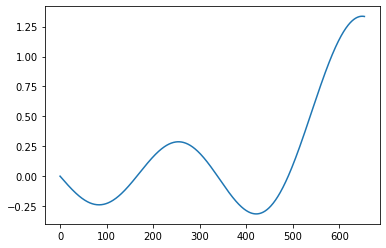

In [45]:
plt.plot(optimizer.gamma)

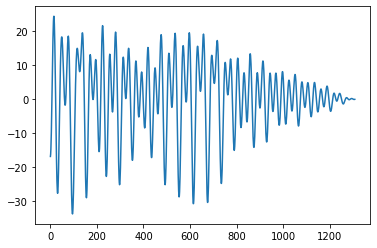

In [29]:
plt.plot(optimizer.phi[3,:])

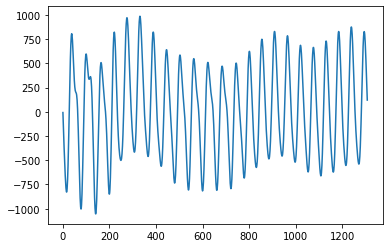

In [30]:
plt.plot(np.sum(optimizer.a,0))